## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

True


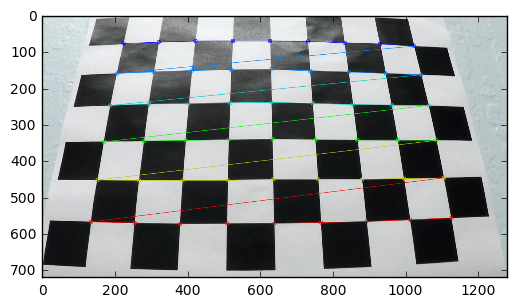

In [1]:
#1.1 finding corners
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = 'camera_calib/calibration3.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
print(ret)
# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.show()

####  extract object points and image points for camera calibration.

In [2]:
#1.2 calibrating camera
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_calib/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Second,I'll apply a distortion correction to raw images.

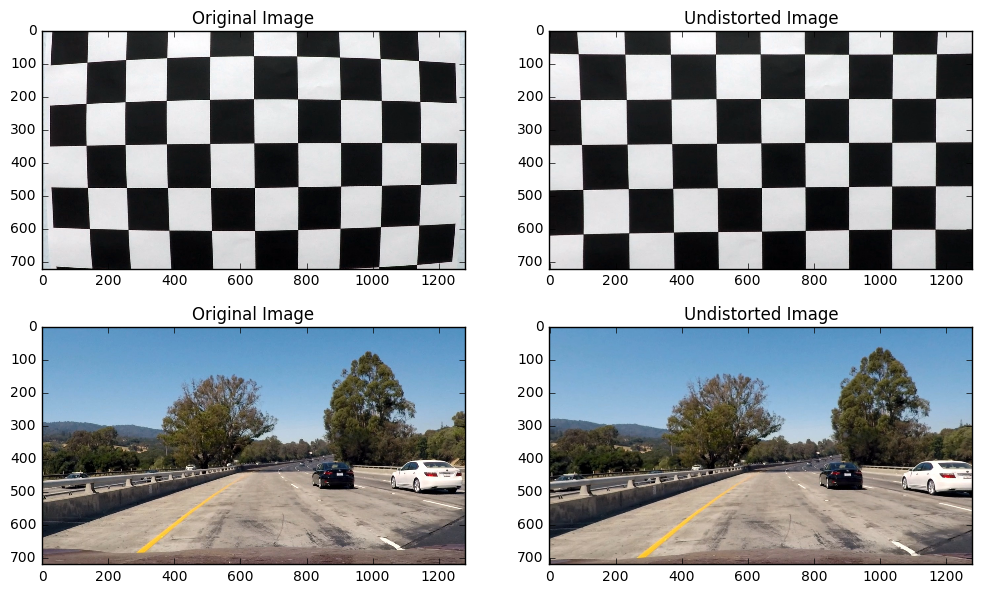

In [3]:
import pickle
%matplotlib inline
# Test undistortion on an image
img = cv2.imread('camera_calib/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

dst = undistort(img)
cv2.imwrite('camera_calib/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calib/wide_dist_pickle.p", "wb" ) )
# Visualize undistortion
plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(dst)
plt.title("Undistorted Image")
img = cv2.imread('test_images/test1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")
plt.savefig("output_images/undistort_output.jpg")

## Then,I'll use color transforms, gradients, etc., to create a thresholded binary image.

### combined color and gradients(abs_sobel,magnitude,direction)  

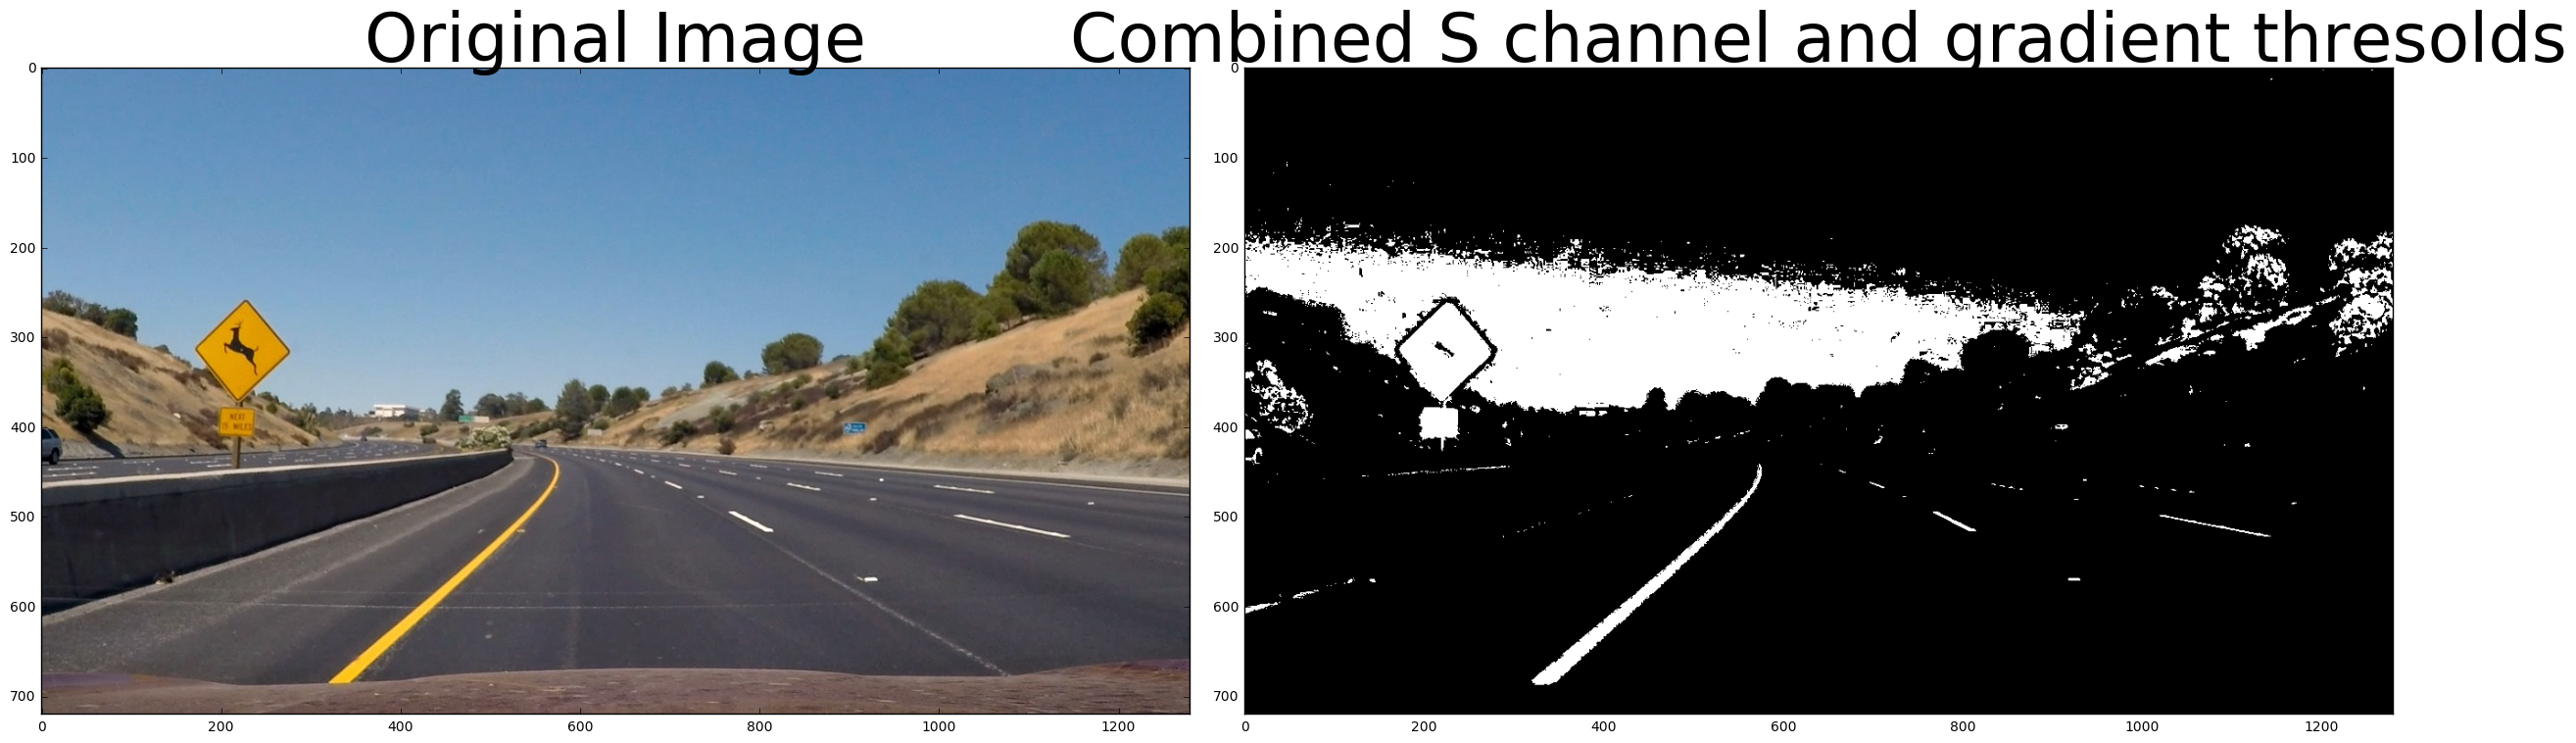

In [201]:
#combined color and gradients
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

##red channel thresh
def red_thresh(img, thresh_min = 25, thresh_max = 255):
    red = img[:,:,2]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh_min) & (red <= thresh_max)]  = 1
    return red_binary

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x',sobel_kernel=3,thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel=cv2.Sobel(gray,cv2.CV_64F,1,0, ksize=sobel_kernel)
    elif orient=='y':
        sobel=cv2.Sobel(gray,cv2.CV_64F,0,1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel=np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh_min)&(scaled_sobel<=thresh_max)]=1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):  
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direct_grad=np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(direct_grad)
    # 6) Return this mask as your binary_output image
    binary_output[(direct_grad>=dir_thresh[0])&(direct_grad<=dir_thresh[1])]=1
    #binary_output = np.copy(img) # Remove this line
    return binary_output

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(120, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    #Choose a Sobel kernel size 
    ksize=3 
    # Apply other thresholding functions
    gradx= abs_sobel_thresh(image, orient='x', sobel_kernel=ksize,thresh_min=20, thresh_max=255)
    grady= abs_sobel_thresh(image, orient='y', sobel_kernel=ksize,thresh_min=20, thresh_max=255)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 255))
    dir_binary = dir_thresh(image,sobel_kernel=ksize,dir_thresh=(0.7,1.3))
    red_binary=red_thresh(image,thresh_min=200)
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack((gradx,grady,s_binary)) * 255
    #combine the binary thresolds
    combined_binary=np.zeros_like(s_binary)
    #combined_binary[(s_binary==1)| ((gradx==1) & (grady==1))|((mag_binary==1)&(dir_binary==1))]=1
    combined_binary[(s_binary==1)| (red_binary==1)]=1
    return combined_binary


# Read in an image and grayscale it
image = mpimg.imread('test_images/test2.jpg')
#Combine thresholded binary images
combined_binary = pipeline(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary,cmap='gray')
ax2.set_title('Combined S channel and gradient thresolds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('combined_thresold_output.jpg')

### Then,I'll Apply a perspective transform to rectify binary image ("birds-eye view").

I chose the hardcode the source and destination points in the
following manner:

src = np.float32(
[[(img_width / 2) - 55, img_height / 2 + 100],
[((img_width / 6) - 10), img_height],
[(img_width * 5 / 6) + 60, img_height],
[(img_width / 2 + 55), img_height / 2 + 100]])
dst = np.float32(
[[(img_width / 4), 0],
[(img_width / 4), img_height],
[(img_width * 3 / 4), img_height],
[(img_width * 3 / 4), 0]])

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

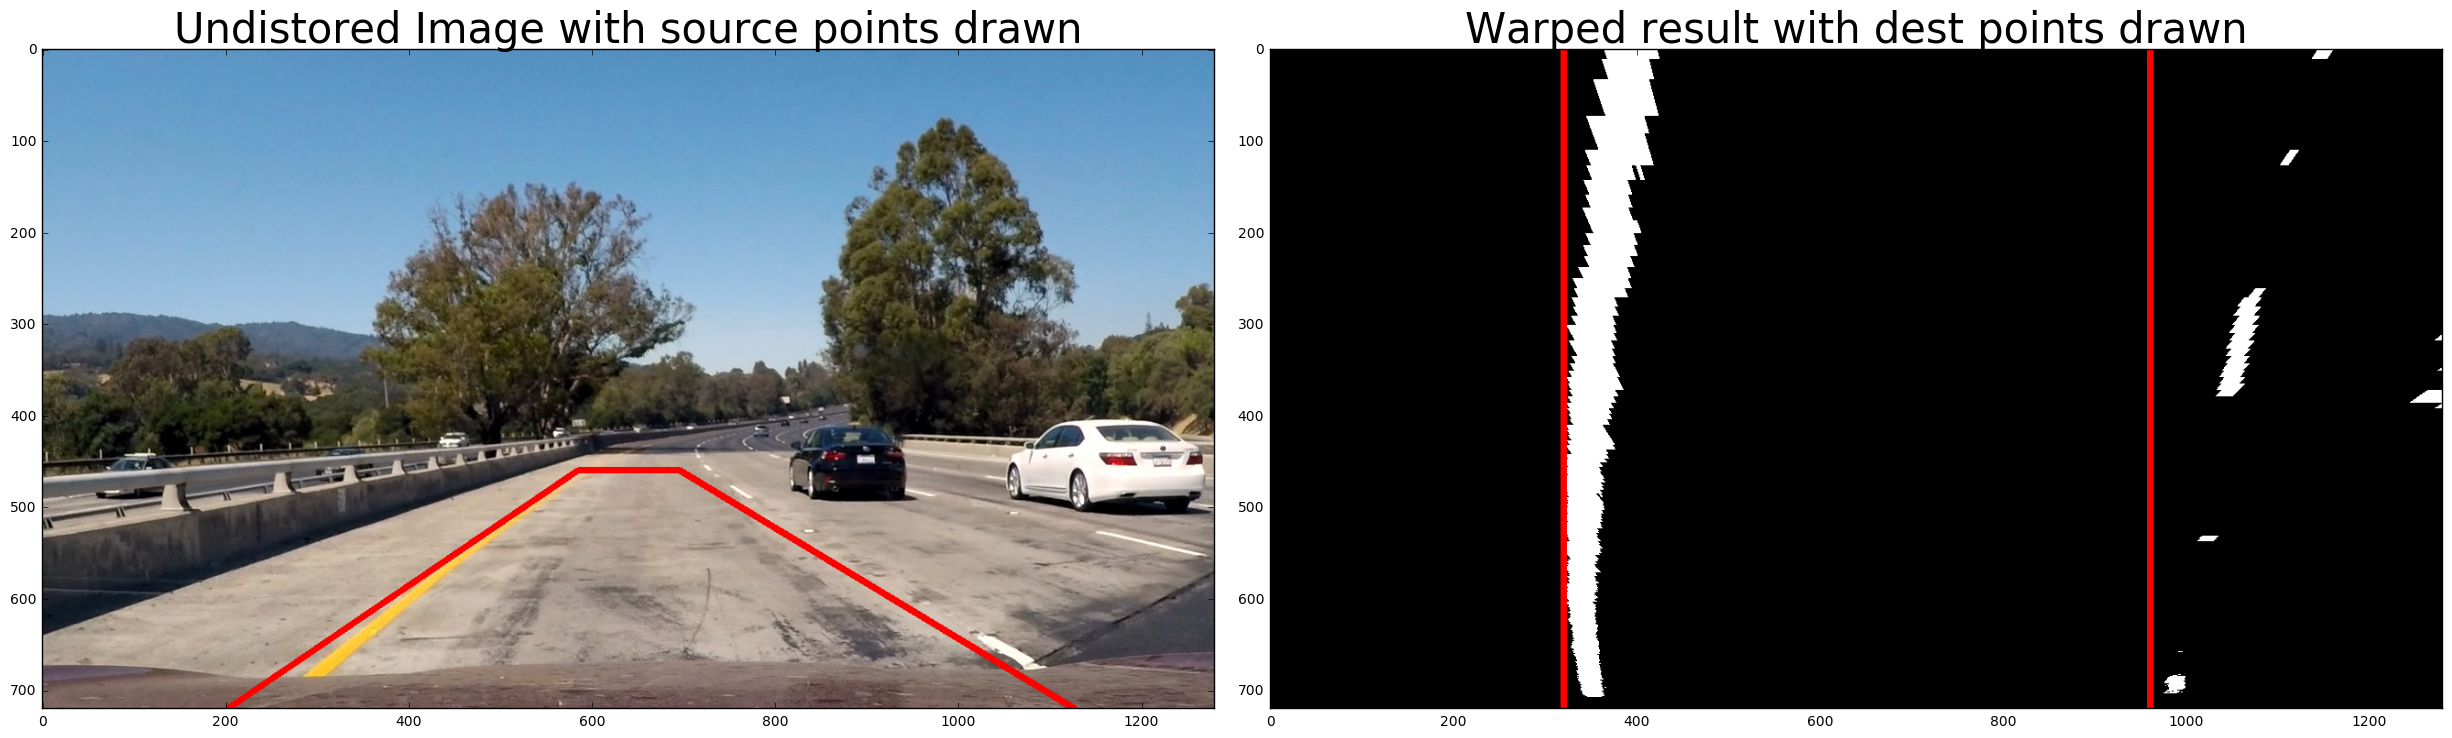

In [202]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def warper(img):
    #hardcode the source and destination points
    src=np.float32(
        [[img_width/2-55,img_height/2+100],
        [img_width/6-10,img_height],
        [img_width*5/6+60,img_height],
        [img_width/2+55,img_height/2+100]])
    dst=np.float32(
        [[img_width/4,0],
        [img_width/4,img_height],
        [img_width*3/4,img_height],
        [img_width*3/4,0]])
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped,M,Minv

# Read in an image and grayscale it
image = mpimg.imread('test_images/test1.jpg')
img_width=image.shape[1]
img_height=image.shape[0]
#hardcode the source and destination points
src=np.float32(
    [[img_width/2-55,img_height/2+100],
    [img_width/6-10,img_height],
    [img_width*5/6+60,img_height],
    [img_width/2+55,img_height/2+100]])
dst=np.float32(
    [[img_width/4,0],
    [img_width/4,img_height],
    [img_width*3/4,img_height],
    [img_width*3/4,0]])
#apply warper
combined_binary=pipeline(image)
warped_binary,M,Minv=warper(combined_binary)

#draw points
src_img=image.copy()
cv2.line(src_img,(src[0][0],src[0][1]),(src[1][0],src[1][1]),(255,0,0),5)
cv2.line(src_img,(src[0][0],src[0][1]),(src[3][0],src[3][1]),(255,0,0),5)
cv2.line(src_img,(src[2][0],src[2][1]),(src[3][0],src[3][1]),(255,0,0),5)



temp=warped_binary.copy()
dst_img = np.dstack((temp, temp, temp))*255
cv2.imwrite('binary.jpg',temp*255)
cv2.line(dst_img,(dst[0][0],dst[0][1]),(dst[1][0],dst[1][1]),(255,0,0),5)
cv2.line(dst_img,(dst[2][0],dst[2][1]),(dst[3][0],dst[3][1]),(255,0,0),5)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_img)
ax1.set_title('Undistored Image with source points drawn', fontsize=30)
ax2.imshow(dst_img)
ax2.set_title('Warped result with dest points drawn', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('warped_straight_lines.jpg')
plt.show()

# Then,I'll Detect lane pixels and fit to find the lane boundary.

The following code *find_lane* detect lanes one the image and visualize the results

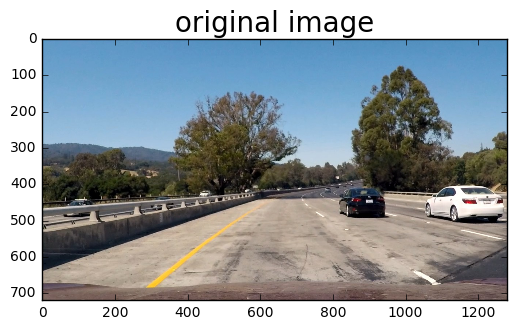

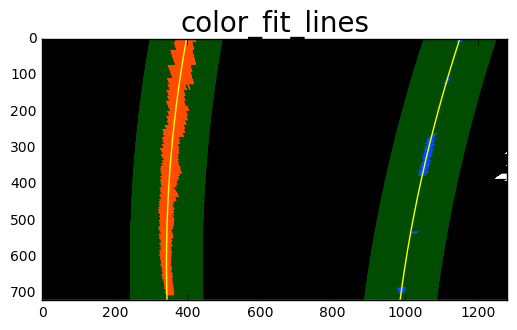

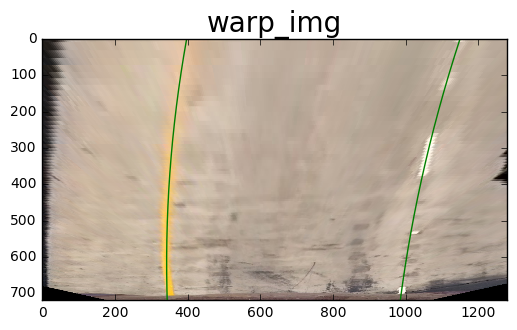

In [203]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_lane(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #then find the lane out
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
      
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_fit,right_fit,left_fitx,right_fitx,result

src=mpimg.imread('test_images/test1.jpg')
combined_binary=pipeline(src)
warped_binary,M,Minv=warper(combined_binary)

f=plt.figure()
plt.imshow(src)
plt.title('original image',fontsize=20)
plt.show()
#binary_warped=mpimg.imread('binary.jpg')
left_fit,right_fit,left_fitx,right_fitx,result=find_lane(warped_binary)
plt.imshow(result,cmap='gray')
ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title('color_fit_lines',fontsize=20)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()
f1=plt.figure()
plt.plot(left_fitx, ploty, color='green')
plt.plot(right_fitx, ploty, color='green')
plt.imshow(warp)
plt.title('warp_img',fontsize=20)
plt.show()

## Determine the curvature of the lane and vehicle position with respect to center.

In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

Max_Radius=10000 #MAX_RADIUS=10000m
def calc_r_curv(leftx,rightx,ploty):
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    if left_curverad>10000:
        left_curverad=10000
    if right_curverad>10000:
        right_curverad=10000
    #average the left&right curvature radius
    r=(left_curverad+right_curverad)/2.0
    # Now our radius of curvature is in meters
    return np.round(r)
    # Example values: 632.1 m    626.2 m
    
def calc_pos(left_fit,right_fit,x):
    maxLeftx=left_fit[0]*x**2+left_fit[1]*x+left_fit[2]
    maxRightx=right_fit[0]*x**2+right_fit[1]*x+right_fit[2]
    pos=1280/2-(maxLeftx+maxRightx)/2.0
    pos=pos*xm_per_pix
    return np.round(pos,2)
    
pos=calc_pos(left_fit,right_fit,719)
r=calc_r_curv(left_fitx,right_fitx,ploty)
print('radius: ',r)
print('pos: ',str(pos)+' m')

radius:  7273.0
pos:  0.05 m


## Warp the detected lane boundaries back onto the original image.

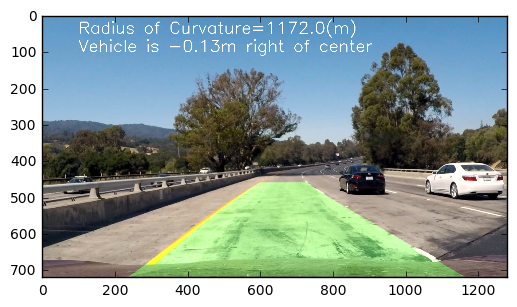

In [206]:
def draw_lanelines(binary_warped,img,left_fit,right_fit,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #calc radius
    r=calc_r_curv(left_fitx,right_fitx,ploty)
    r_text='Radius of Curvature='+str(r)+'(m)'
    #calc pos
    pos=calc_pos(left_fit,right_fit,719)
    direct='mid'
    if pos>0:
        direct='left'
    if pos<0:
        direct='right'
    pos_text='Vehicle is '+str(pos)+'m '+direct+' of center'
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,r_text,  (100,50),font,1.5,(255,255,255),2)
    cv2.putText(result,pos_text,(100,100),font,1.5,(255,255,255),2)
    return result


warped_binary=mpimg.imread('binary.jpg')
result=draw_lanelines(warped_binary,src,left_fit,right_fit,left_fitx,right_fitx)
plt.imshow(result)
#plt.savefig('output_images/findlanes_output.jpg')

## Finally,Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The following *process* function is based on all the functions above,it can detect the lanes with the original input images.

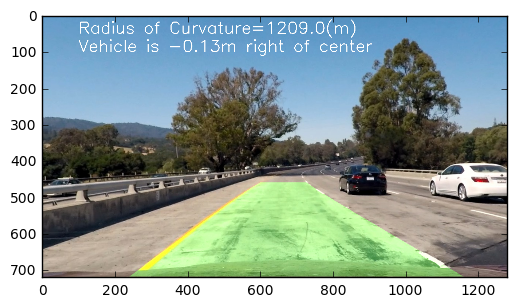

In [208]:
#process images
def process(img):
    #undistort original image
    dist=undistort(img)
    #get the combined threshold binary image
    combined_binary=pipeline(dist)
    #perspetive transform of the undistor image
    warped_binary,M,Minv=warper(combined_binary)
    #find lane on the binary image
    left_fit,right_fit,left_fitx,right_fitx,draw_result=find_lane(warped_binary)
    #darw_lanelines on the original image
    result=draw_lanelines(warped_binary,dist,left_fit,right_fit,left_fitx,right_fitx)
    return result

#img=mpimg.imread('test_images/straight_lines2.jpg')
img=mpimg.imread('test_images/test1.jpg')
result=process(img)
f=plt.figure()
plt.imshow(result)

## Video Processing

Now I'll process the project videos 

In [209]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

#process videos
output_path='output_videos/project_video_result.mp4'
project_clip=VideoFileClip("project_video.mp4")
clip=project_clip.fl_image(process)
%time clip.write_videofile(output_path,audio=False)

[MoviePy] >>>> Building video output_videos/project_video_result.mp4
[MoviePy] Writing video output_videos/project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:22<00:00,  4.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_result.mp4 

Wall time: 4min 23s


In [210]:
#process challenge videos
output_path='output_videos/challenge_video_result.mp4'
project_clip=VideoFileClip("challenge_video.mp4")
clip=project_clip.fl_image(process)
%time clip.write_videofile(output_path,audio=False)

output_path='output_videos/harder_challenge_video_result.mp4'
project_clip=VideoFileClip("harder_challenge_video.mp4")
clip=project_clip.fl_image(process)
%time clip.write_videofile(output_path,audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_result.mp4
[MoviePy] Writing video output_videos/challenge_video_result.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:37<00:00,  5.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_result.mp4 

Wall time: 1min 38s
[MoviePy] >>>> Building video output_videos/harder_challenge_video_result.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [04:52<00:00,  4.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_result.mp4 

Wall time: 4min 53s
